## References:

https://www.kaggle.com/selfishgene/historical-hourly-weather-data

https://www.kaggle.com/nitinsss/time-series-prediction-with-keras-for-beginners

In [1]:
import pandas as pd
import matplotlib.pyplot as plt # data visualization

In [2]:
SENSOR = 'pressure'
df = pd.read_csv('data/{}.csv'.format(SENSOR), index_col='datetime')

In [3]:
df.interpolate(inplace=True)

In [4]:
df.head(3)

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1011.0,NaN,NaN,NaN
2012-10-01 13:00:00,NaN,1024.0,1009.0,1027.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,...,1014.0,1012.0,1001.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0
2012-10-01 14:00:00,NaN,1024.0,1009.0,1027.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,...,1014.0,1012.0,986.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0


In [5]:
CITY = 'Seattle'
df_city = pd.DataFrame(df[CITY])
df_city.columns = [SENSOR]
df_city.head()

,pressure
datetime,
2012-10-01 12:00:00,NaN
2012-10-01 13:00:00,1027.0
2012-10-01 14:00:00,1027.0
2012-10-01 15:00:00,1028.0
2012-10-01 16:00:00,1028.0


In [6]:
df_city.dropna(inplace=True)
df_city.shape

(45252, 1)

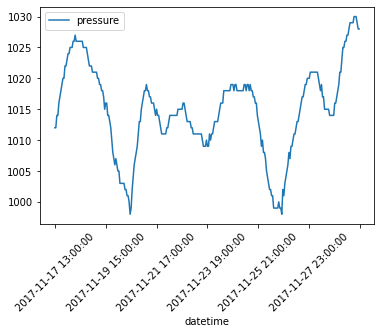

In [7]:
df_city.tail(300).plot()
plt.xticks(rotation=45)
plt.show()

In [8]:
# Finding Regressor Inputs
from statsmodels.tsa import stattools

acf, confint, qstat, pvalues = stattools.acf(df_city,
                                            unbiased=True,
                                            nlags=20,
                                            qstat=True,
                                            fft=True,
                                            alpha = 0.05)


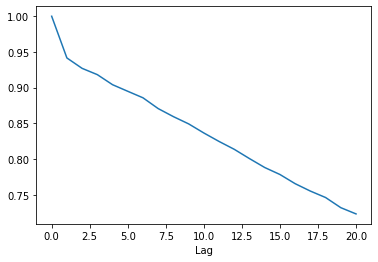

In [9]:
pd.Series(acf).plot()
plt.xlabel('Lag')
plt.show()

In [28]:
act_threshold = .9
acf_city = pd.Series(acf)
fe_nhoras = acf_city[acf_city > act_threshold].index.values.max() + 1
print('Número de horas a tener en cuenta: ', fe_nhoras)

Número de horas a tener en cuenta:  5


In [29]:
def add_regressor_attributes(pandas_df, column_name, nhoras):
    X = pandas_df.copy()
    for fhora in range(1, nhoras + 1, 1):
        X[column_name + '-h-' + str(fhora)] = X[column_name].shift(fhora)

    # Borrar los registros que tienen algún valor NaN
    X.dropna(inplace=True)
    return X

df_full = add_regressor_attributes(df_city, SENSOR, nhoras=fe_nhoras)

print(CITY)
df_full.head(2)

Seattle


,pressure,pressure-h-1,pressure-h-2,pressure-h-3,pressure-h-4,pressure-h-5
datetime,,,,,,
2012-10-01 18:00:00,1030.0,1029.0,1028.0,1028.0,1027.0,1027.0
2012-10-01 19:00:00,1031.0,1030.0,1029.0,1028.0,1028.0,1027.0


In [30]:
unseen_from = str(pd.to_datetime(df_full.index.max()) - pd.Timedelta('15D'))
df_unseen = df_full.loc[unseen_from:df_full.index.max()].copy()
df_new = df_full.loc[:unseen_from].copy()

## ML

In [31]:
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [32]:
input_layer = Input(shape=(len(df_new.columns.values)-1), dtype='float32')
dense1 = Dense(60, activation='linear')(input_layer)
dense2 = Dense(60, activation='linear')(dense1)
dropout_layer = Dropout(0.2)(dense2)
output_layer = Dense(1, activation='linear')(dropout_layer)

In [33]:
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 60)                360       
_________________________________________________________________
dense_4 (Dense)              (None, 60)                3660      
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 61        
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
_________________________________________________________________


## Spliting the data

In [34]:
test_set_size = 0.05
valid_set_size= 0.1

df_copy = df_new.reset_index(drop=True)

df_test = df_copy.iloc[ int(pd.np.floor(len(df_copy)*(1-test_set_size))) : ]
df_train_plus_valid = df_copy.iloc[ : int(pd.np.floor(len(df_copy)*(1-test_set_size))) ]

df_train = df_train_plus_valid.iloc[ : int(pd.np.floor(len(df_train_plus_valid)*(1-valid_set_size))) ]
df_valid = df_train_plus_valid.iloc[ int(pd.np.floor(len(df_train_plus_valid)*(1-valid_set_size))) : ]


X_train, y_train = df_train.iloc[:, 1:], df_train.iloc[:, 0]
X_valid, y_valid = df_valid.iloc[:, 1:], df_valid.iloc[:, 0]
X_test, y_test = df_test.iloc[:, 1:], df_test.iloc[:, 0]

print('Shape of training inputs, training target:', X_train.shape, y_train.shape)
print('Shape of validation inputs, validation target:', X_valid.shape, y_valid.shape)
print('Shape of test inputs, test target:', X_test.shape, y_test.shape)

Shape of training inputs, training target: (38377, 5) (38377,)
Shape of validation inputs, validation target: (4265, 5) (4265,)
Shape of test inputs, test target: (2245, 5) (2245,)


In [35]:
print('X_train:', X_train.index)
print('X_valid:', X_valid.index)
print('X_test: ', X_test.index)

X_train: RangeIndex(start=0, stop=38377, step=1)
X_valid: RangeIndex(start=38377, stop=42642, step=1)
X_test:  RangeIndex(start=42642, stop=44887, step=1)


## Scaling the data

In [36]:
from sklearn.preprocessing import MinMaxScaler

Target_scaler = MinMaxScaler(feature_range=(0.01, 0.99))
Feature_scaler = MinMaxScaler(feature_range=(0.01, 0.99))

X_train_scaled = Feature_scaler.fit_transform(pd.np.array(X_train))
X_valid_scaled = Feature_scaler.fit_transform(pd.np.array(X_valid))
X_test_scaled = Feature_scaler.fit_transform(pd.np.array(X_test))

y_train_scaled = Target_scaler.fit_transform(pd.np.array(y_train).reshape(-1,1))
y_valid_scaled = Target_scaler.fit_transform(pd.np.array(y_valid).reshape(-1,1))
y_test_scaled = Target_scaler.fit_transform(pd.np.array(y_test).reshape(-1,1))


## Training and Validation

In [37]:
early_stopping = EarlyStopping(
    min_delta=0.01, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)
history = model.fit(x=X_train_scaled, y=y_train_scaled, batch_size=5, epochs=30, verbose=1, validation_data=(X_valid_scaled, y_valid_scaled), shuffle=True, callbacks=[early_stopping])

Epoch 1/30
7676/7676 [==============================] - 4s 550us/step - loss: 0.0149 - val_loss: 6.9641e-04
Epoch 2/30
7676/7676 [==============================] - 4s 549us/step - loss: 0.0021 - val_loss: 7.4908e-04
Epoch 3/30
7676/7676 [==============================] - 4s 548us/step - loss: 0.0019 - val_loss: 9.9998e-04
Epoch 4/30
7676/7676 [==============================] - 4s 545us/step - loss: 0.0018 - val_loss: 7.7314e-04
Epoch 5/30
7676/7676 [==============================] - 4s 544us/step - loss: 0.0019 - val_loss: 7.0718e-04
Epoch 6/30
7676/7676 [==============================] - 4s 547us/step - loss: 0.0019 - val_loss: 7.7584e-04


Minimum Validation Loss: 0.0007


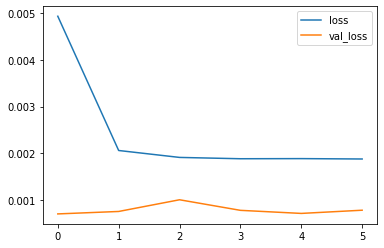

In [38]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

In [39]:
y_pred = model.predict(X_test_scaled)

In [40]:
y_pred_rescaled = Target_scaler.inverse_transform(y_pred)

In [41]:
from sklearn.metrics import r2_score
y_test_rescaled =  Target_scaler.inverse_transform(y_test_scaled)
score = r2_score(y_test_rescaled, y_pred_rescaled)
print('More the r2 score closer to one, better the predictions of your model')
print('R-squared score for the test set:', round(score,4))

More the r2 score closer to one, better the predictions of your model
R-squared score for the test set: 0.9733


## Plotting the predictions

In [42]:
y_actual = pd.DataFrame(y_test_rescaled, columns=['Actual'])
y_hat = pd.DataFrame(y_pred_rescaled, columns=['Predicted'])

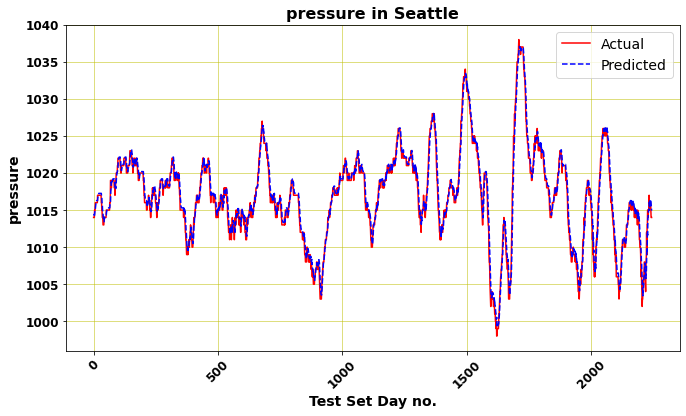

In [43]:
plt.figure(figsize=(11, 6))
plt.plot(y_actual, linestyle='solid', color='r')
plt.plot(y_hat, linestyle='dashed', color='b')

plt.legend(['Actual','Predicted'], loc='best', prop={'size': 14})
plt.title('{} in {}'.format(SENSOR, CITY), weight='bold', fontsize=16)
plt.ylabel(SENSOR, weight='bold', fontsize=14)
plt.xlabel('Test Set Day no.', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth='0.5')
plt.show()

## Unseen data

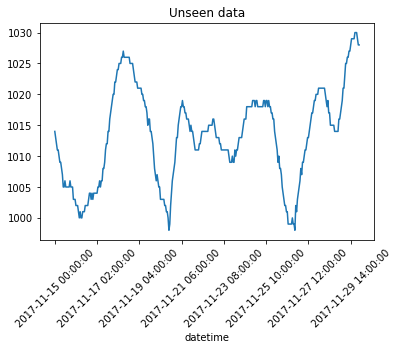

In [44]:
df_unseen[SENSOR].plot(title='Unseen data')
plt.xticks(rotation=45)
plt.show()

In [45]:
# @todo: Preprocess + predictions